In [1]:
!pip install graphviz==0.20.3


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import duckdb
import logging
from datetime import date
from graphviz import Digraph
import os

# --------------------------------------------------
# Setup Logging
# --------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# --------------------------------------------------
# 1. Extraction: Load Data from CSV and Data Cleaning
# --------------------------------------------------
try:
    # Load CSV data
    df = pd.read_csv("Online_Retail.csv", encoding="latin1")
    logger.info("Data loaded successfully with shape: %s", df.shape)
    
    # Remove duplicate rows
    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    logger.info("Duplicates removed: %d rows dropped", initial_count - len(df))
    
    # Remove rows with missing critical values (InvoiceNo, StockCode, InvoiceDate, Quantity, UnitPrice)
    required_cols = ['InvoiceNo', 'StockCode', 'InvoiceDate', 'Quantity', 'UnitPrice']
    df.dropna(subset=required_cols, inplace=True)
    logger.info("Rows with nulls in critical columns removed. Current shape: %s", df.shape)
    
    # Convert InvoiceDate to datetime; drop rows where conversion fails
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    df = df[df['InvoiceDate'].notnull()]
    logger.info("InvoiceDate conversion completed. Current shape: %s", df.shape)
    
    # Remove rows with negative UnitPrice if they are considered errors
    neg_unitprice_count = (df['UnitPrice'] < 0).sum()
    if neg_unitprice_count > 0:
        logger.warning("Found %d rows with negative UnitPrice. These rows will be removed.", neg_unitprice_count)
        df = df[df['UnitPrice'] >= 0]
    logger.info("Final shape after data cleaning: %s", df.shape)
    
    # Compute Revenue column
    df['Revenue'] = df['Quantity'] * df['UnitPrice']
    logger.info("Revenue column calculated.")
except Exception as e:
    logger.error("Error in Extraction and Cleaning step: %s", e)
    raise

# --------------------------------------------------
# 2. Transformation: Build the Star Schema
# --------------------------------------------------

# Build DateDimension
try:
    date_df = df[['InvoiceDate']].drop_duplicates().reset_index(drop=True)
    date_df['DateKey'] = date_df.index + 1
    date_df['FullDate'] = date_df['InvoiceDate'].dt.date
    date_df['Year'] = date_df['InvoiceDate'].dt.year
    date_df['Month'] = date_df['InvoiceDate'].dt.month
    date_df['Day'] = date_df['InvoiceDate'].dt.day
    date_df['Quarter'] = date_df['InvoiceDate'].dt.quarter
    date_df['DayOfWeek'] = date_df['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
    date_dim = date_df[['DateKey','FullDate','Year','Month','Day','Quarter','DayOfWeek']].copy()
    logger.info("Transformation: DateDimension built with %s rows", len(date_dim))
except Exception as e:
    logger.error("Error building DateDimension: %s", e)
    raise

# Build ProductDimension
try:
    product_df = df[['StockCode','Description']].drop_duplicates().reset_index(drop=True)
    product_df['ProductKey'] = product_df.index + 1
    product_dim = product_df[['ProductKey','StockCode','Description']].copy()
    logger.info("Transformation: ProductDimension built with %s rows", len(product_dim))
except Exception as e:
    logger.error("Error building ProductDimension: %s", e)
    raise

# Build CustomerDimension with SCD Type 2 columns
try:
    customer_df = df[['CustomerID','Country']].dropna(subset=['CustomerID']).drop_duplicates().copy()
    customer_df['CustomerID'] = customer_df['CustomerID'].astype(int).astype(str)
    customer_df = customer_df.reset_index(drop=True)
    customer_df['CustomerKey'] = customer_df.index + 1
    today_date = date.today()  # plain Python date
    customer_dim = customer_df[['CustomerKey','CustomerID','Country']].copy()
    customer_dim['EffectiveDate'] = today_date
    customer_dim['EndDate'] = None
    customer_dim['IsCurrent'] = True
    logger.info("Transformation: CustomerDimension built with %s rows", len(customer_dim))
except Exception as e:
    logger.error("Error building CustomerDimension: %s", e)
    raise

# Build InvoiceDimension (4th Dimension)
try:
    invoice_df = df[['InvoiceNo','InvoiceDate','Country']].drop_duplicates().reset_index(drop=True)
    invoice_df['InvoiceKey'] = invoice_df.index + 1
    invoice_dim = invoice_df[['InvoiceKey','InvoiceNo','InvoiceDate','Country']].copy()
    invoice_dim['InvoiceDate'] = invoice_dim['InvoiceDate'].dt.date
    logger.info("Transformation: InvoiceDimension built with %s rows", len(invoice_dim))
except Exception as e:
    logger.error("Error building InvoiceDimension: %s", e)
    raise

# Build FactSales table
try:
    df_for_fact = pd.merge(df, date_df[['InvoiceDate','DateKey']], on='InvoiceDate', how='left')
    df_for_fact = pd.merge(
        df_for_fact, 
        product_df[['StockCode','Description','ProductKey']], 
        on=['StockCode','Description'],
        how='left'
    )
    df_for_fact['CustomerID'] = df_for_fact['CustomerID'].astype('float').astype('Int64').astype(str)
    df_for_fact = pd.merge(
        df_for_fact,
        customer_df[['CustomerID','Country','CustomerKey']],
        left_on=['CustomerID','Country'],
        right_on=['CustomerID','Country'],
        how='left'
    )
    df_for_fact = pd.merge(
        df_for_fact,
        invoice_dim[['InvoiceNo','InvoiceKey']],
        on='InvoiceNo',
        how='left'
    )
    fact_sales = df_for_fact[[
        'InvoiceNo',    
        'DateKey',
        'ProductKey',
        'CustomerKey',
        'InvoiceKey',
        'Quantity',
        'UnitPrice',
        'Revenue'
    ]].copy()
    fact_sales = fact_sales.reset_index(drop=True)
    fact_sales['SalesKey'] = fact_sales.index + 1
    fact_sales = fact_sales[[
        'SalesKey',
        'DateKey',
        'ProductKey',
        'CustomerKey',
        'InvoiceKey',
        'Quantity',
        'UnitPrice',
        'Revenue'
    ]]
    logger.info("Transformation: FactSales built with %s rows", len(fact_sales))
except Exception as e:
    logger.error("Error building FactSales: %s", e)
    raise

# --------------------------------------------------
# 2.7 Generate ERD Diagram using Graphviz
# --------------------------------------------------
try:
    dot = Digraph(comment='Star Schema ERD', format='png')

    dot.node('DateDimension', '''DateDimension
------------------
PK: DateKey
FullDate
Year
Month
Day
Quarter
DayOfWeek''')

    dot.node('ProductDimension', '''ProductDimension
------------------
PK: ProductKey
StockCode
Description''')

    dot.node('CustomerDimension', '''CustomerDimension
------------------
PK: CustomerKey
CustomerID
Country
EffectiveDate
EndDate
IsCurrent''')

    dot.node('InvoiceDimension', '''InvoiceDimension
------------------
PK: InvoiceKey
InvoiceNo
InvoiceDate
Country''')

    dot.node('FactSales', '''FactSales
------------------
PK: SalesKey
FK: DateKey
FK: ProductKey
FK: CustomerKey
FK: InvoiceKey
Quantity
UnitPrice
Revenue''')

    dot.edge('DateDimension', 'FactSales', label='DateKey (FK)')
    dot.edge('ProductDimension', 'FactSales', label='ProductKey (FK)')
    dot.edge('CustomerDimension', 'FactSales', label='CustomerKey (FK)')
    dot.edge('InvoiceDimension', 'FactSales', label='InvoiceKey (FK)')

    # Ensure the output directory exists
    output_dir = "output"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    dot.render('StarSchema_ERD', directory=output_dir, view=False)
    logger.info("ERD diagram generated and saved as 'output/StarSchema_ERD.png'.")
except Exception as e:
    logger.error("Error generating ERD diagram: %s", e)
    raise

# --------------------------------------------------
# 3. Loading: Insert Data into DuckDB
# --------------------------------------------------
try:
    db_path = "online_retail.duckdb"
    con = duckdb.connect(db_path)
    logger.info("Connected to DuckDB at %s", db_path)
except Exception as e:
    logger.error("Error connecting to DuckDB: %s", e)
    raise

try:
    con.execute("CREATE SCHEMA IF NOT EXISTS retail")
    logger.info("Schema 'retail' is ready.")

    con.execute("""
        CREATE OR REPLACE TABLE retail.DateDimension (
            DateKey INTEGER,
            FullDate DATE,
            Year INT,
            Month INT,
            Day INT,
            Quarter INT,
            DayOfWeek INT
        )
    """)
    logger.info("Table retail.DateDimension created.")

    con.execute("""
        CREATE OR REPLACE TABLE retail.ProductDimension (
            ProductKey INTEGER,
            StockCode VARCHAR,
            Description VARCHAR
        )
    """)
    logger.info("Table retail.ProductDimension created.")

    con.execute("""
        CREATE OR REPLACE TABLE retail.CustomerDimension (
            CustomerKey INTEGER,
            CustomerID VARCHAR,
            Country VARCHAR,
            EffectiveDate DATE,
            EndDate DATE,
            IsCurrent BOOLEAN
        )
    """)
    logger.info("Table retail.CustomerDimension created.")

    con.execute("""
        CREATE OR REPLACE TABLE retail.InvoiceDimension (
            InvoiceKey INTEGER,
            InvoiceNo VARCHAR,
            InvoiceDate DATE,
            Country VARCHAR
        )
    """)
    logger.info("Table retail.InvoiceDimension created.")

    con.execute("""
        CREATE OR REPLACE TABLE retail.FactSales (
            SalesKey INTEGER,
            DateKey INTEGER,
            ProductKey INTEGER,
            CustomerKey INTEGER,
            InvoiceKey INTEGER,
            Quantity INTEGER,
            UnitPrice DOUBLE,
            Revenue DOUBLE
        )
    """)
    logger.info("Table retail.FactSales created.")
except Exception as e:
    logger.error("Error creating tables: %s", e)
    raise

try:
    con.execute("DELETE FROM retail.DateDimension")
    con.execute("DELETE FROM retail.ProductDimension")
    con.execute("DELETE FROM retail.CustomerDimension")
    con.execute("DELETE FROM retail.InvoiceDimension")
    con.execute("DELETE FROM retail.FactSales")
    logger.info("Cleared existing data from DuckDB tables.")
except Exception as e:
    logger.error("Error clearing tables: %s", e)
    raise

def load_df_to_duckdb(con, table_name, df, temp_view_name):
    try:
        con.register(temp_view_name, df)
        con.execute(f"INSERT INTO retail.{table_name} SELECT * FROM {temp_view_name}")
        con.unregister(temp_view_name)
        logger.info("Data inserted into retail.%s", table_name)
    except Exception as e:
        logger.error("Error inserting data into retail.%s: %s", table_name, e)
        raise

try:
    load_df_to_duckdb(con, "DateDimension", date_dim, "tmp_date_dim")
    load_df_to_duckdb(con, "ProductDimension", product_dim, "tmp_product_dim")
    load_df_to_duckdb(con, "CustomerDimension", customer_dim, "tmp_customer_dim")
    load_df_to_duckdb(con, "InvoiceDimension", invoice_dim, "tmp_invoice_dim")
    load_df_to_duckdb(con, "FactSales", fact_sales, "tmp_fact_sales")
except Exception as e:
    logger.error("Error during data insertion: %s", e)
    raise

# --------------------------------------------------
# 4. Incremental Load & SCD Type 2 Update for CustomerDimension
# --------------------------------------------------
try:
    new_customers = pd.DataFrame({
        'CustomerID': ['17850', '13047', '99999'],
        'Country': ['France', 'Spain', 'Germany']
    })
    logger.info("Incremental data prepared with %s rows", len(new_customers))

    current_customers = con.execute("SELECT * FROM retail.CustomerDimension WHERE IsCurrent = TRUE").df()

    for idx, row in new_customers.iterrows():
        cust_id = row['CustomerID']
        new_country = row['Country']
        existing = current_customers[current_customers['CustomerID'] == cust_id]
        if not existing.empty:
            current_country = existing.iloc[0]['Country']
            if current_country != new_country:
                con.execute(f"""
                    UPDATE retail.CustomerDimension
                    SET EndDate = CURRENT_DATE, IsCurrent = FALSE
                    WHERE CustomerID = '{cust_id}' AND IsCurrent = TRUE
                """)
                logger.info("Customer %s: Existing record expired.", cust_id)
                max_key = con.execute("SELECT MAX(CustomerKey) FROM retail.CustomerDimension").fetchone()[0]
                new_key = max_key + 1 if max_key is not None else 1
                con.execute(f"""
                    INSERT INTO retail.CustomerDimension (CustomerKey, CustomerID, Country, EffectiveDate, EndDate, IsCurrent)
                    VALUES ({new_key}, '{cust_id}', '{new_country}', CURRENT_DATE, NULL, TRUE)
                """)
                logger.info("Customer %s: New version inserted with changed country '%s'.", cust_id, new_country)
            else:
                logger.info("Customer %s: No changes detected.", cust_id)
        else:
            max_key = con.execute("SELECT MAX(CustomerKey) FROM retail.CustomerDimension").fetchone()[0]
            new_key = max_key + 1 if max_key is not None else 1
            con.execute(f"""
                INSERT INTO retail.CustomerDimension (CustomerKey, CustomerID, Country, EffectiveDate, EndDate, IsCurrent)
                VALUES ({new_key}, '{cust_id}', '{new_country}', CURRENT_DATE, NULL, TRUE)
            """)
            logger.info("New customer %s inserted with country '%s'.", cust_id, new_country)
except Exception as e:
    logger.error("Error during incremental SCD Type 2 update: %s", e)
    raise

# --------------------------------------------------
# 5. Verification: Summary and Samples for Each Table (Pretty Format)
# --------------------------------------------------
try:
    date_count = con.execute("SELECT COUNT(*) FROM retail.DateDimension").fetchone()[0]
    product_count = con.execute("SELECT COUNT(*) FROM retail.ProductDimension").fetchone()[0]
    customer_count = con.execute("SELECT COUNT(*) FROM retail.CustomerDimension").fetchone()[0]
    invoice_count = con.execute("SELECT COUNT(*) FROM retail.InvoiceDimension").fetchone()[0]
    fact_count = con.execute("SELECT COUNT(*) FROM retail.FactSales").fetchone()[0]
    
    print("\n================== Final Summary ==================")
    print(f"DateDimension:     {date_count} rows")
    print(f"ProductDimension:  {product_count} rows")
    print(f"CustomerDimension: {customer_count} rows")
    print(f"InvoiceDimension:  {invoice_count} rows")
    print(f"FactSales:         {fact_count} rows")
    print("===================================================\n")
    
    date_sample = con.execute("SELECT * FROM retail.DateDimension LIMIT 5").df()
    product_sample = con.execute("SELECT * FROM retail.ProductDimension LIMIT 5").df()
    customer_sample = con.execute("SELECT * FROM retail.CustomerDimension LIMIT 5").df()
    invoice_sample = con.execute("SELECT * FROM retail.InvoiceDimension LIMIT 5").df()
    fact_sample = con.execute("SELECT * FROM retail.FactSales LIMIT 5").df()
    
    def pretty_print_df(df, title):
        print(f"----- {title} -----")
        try:
            print(df.to_markdown(index=False))
        except Exception as e:
            print(df.to_string(index=False))
        print("\n")
    
    pretty_print_df(date_sample, "Sample from DateDimension")
    pretty_print_df(product_sample, "Sample from ProductDimension")
    pretty_print_df(customer_sample, "Sample from CustomerDimension")
    pretty_print_df(invoice_sample, "Sample from InvoiceDimension")
    pretty_print_df(fact_sample, "Sample from FactSales")
    
except Exception as e:
    logger.error("Error during final summary and sample retrieval: %s", e)
    raise

# --------------------------------------------------
# 6. Close the DuckDB Connection
# --------------------------------------------------
try:
    con.close()
    logger.info("DuckDB connection closed.")
except Exception as e:
    logger.error("Error closing DuckDB connection: %s", e)


2025-03-22 03:34:16,263 - INFO - Data loaded successfully with shape: (541909, 8)
2025-03-22 03:34:16,613 - INFO - Duplicates removed: 5268 rows dropped
2025-03-22 03:34:16,709 - INFO - Rows with nulls in critical columns removed. Current shape: (536641, 8)
/tmp/ipykernel_205/733160209.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
2025-03-22 03:34:18,818 - INFO - InvoiceDate conversion completed. Current shape: (536641, 8)
2025-03-22 03:34:18,820 - WARNING - Found 2 rows with negative UnitPrice. These rows will be removed.
2025-03-22 03:34:18,855 - INFO - Final shape after data cleaning: (536639, 8)
2025-03-22 03:34:18,860 - INFO - Revenue column calculated.
2025-03-22 03:34:18,887 - INFO - Transformation: DateDimension built with 23258 rows
2025-03-22 03:34:19,008 - INFO

2025-03-22 03:34:28,236 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-22 03:34:28,239 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


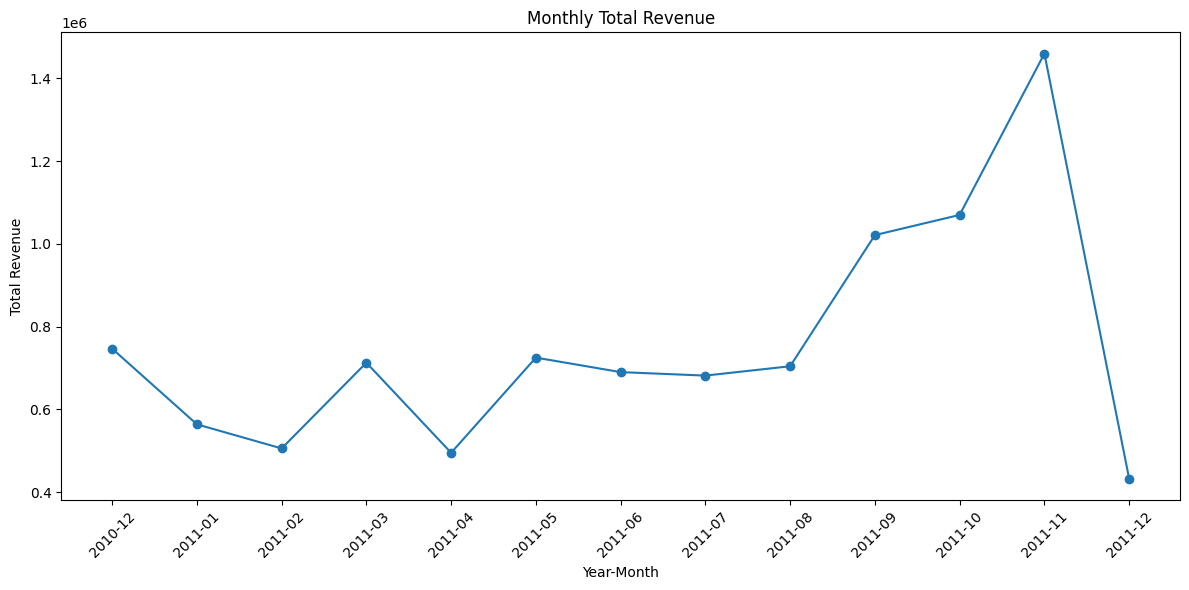

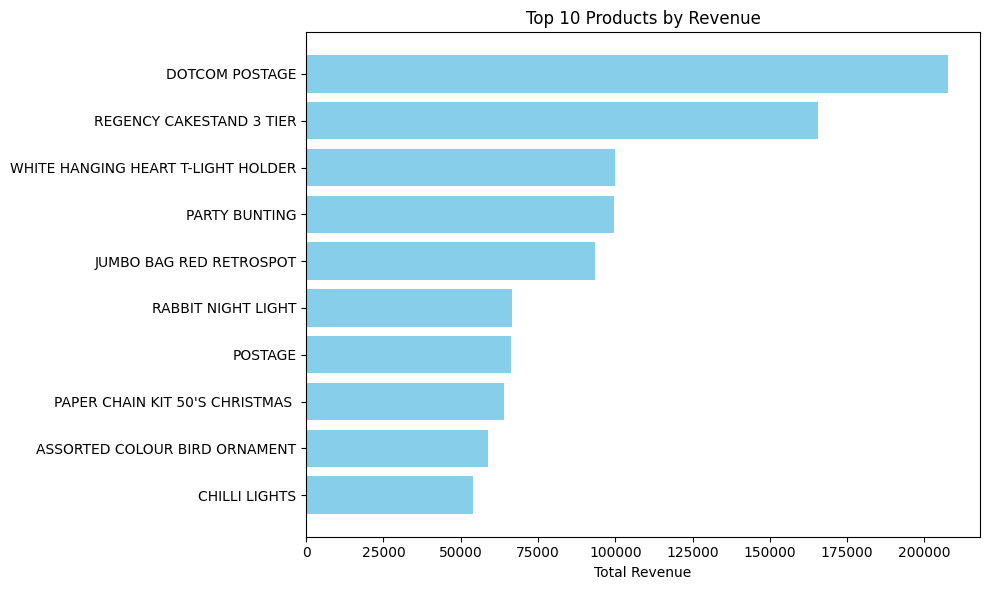

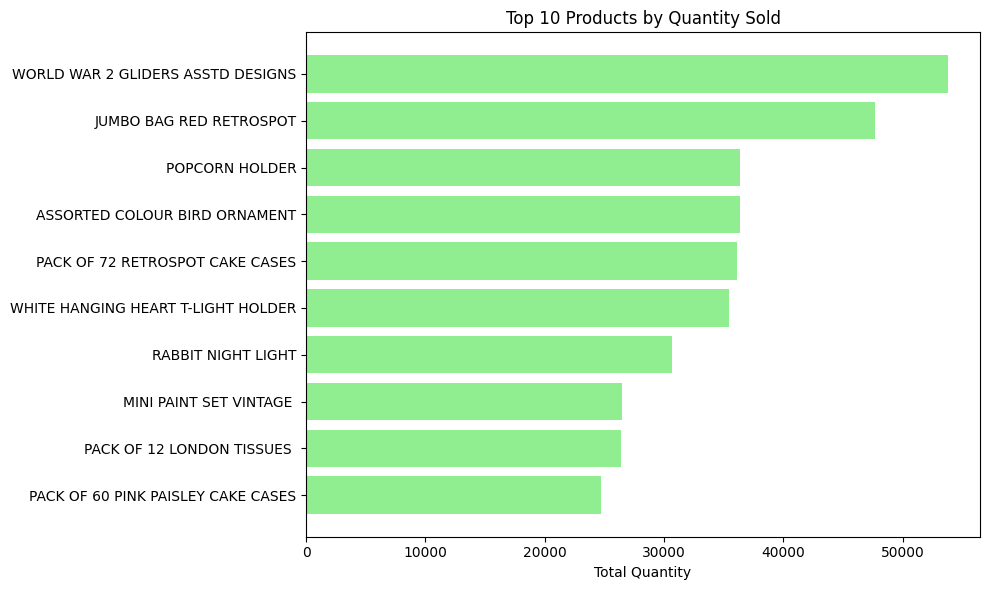

2025-03-22 03:34:36,180 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-22 03:34:36,181 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Top 5 Product Pairs (Cross-sell Opportunities):
| Product1                          | Product2                        |   PairCount |
|:----------------------------------|:--------------------------------|------------:|
| JUMBO BAG PINK POLKADOT           | JUMBO BAG RED RETROSPOT         |         838 |
| ROSES REGENCY TEACUP AND SAUCER   | GREEN REGENCY TEACUP AND SAUCER |         788 |
| JUMBO STORAGE BAG SUKI            | JUMBO BAG RED RETROSPOT         |         740 |
| JUMBO SHOPPER VINTAGE RED PAISLEY | JUMBO BAG RED RETROSPOT         |     

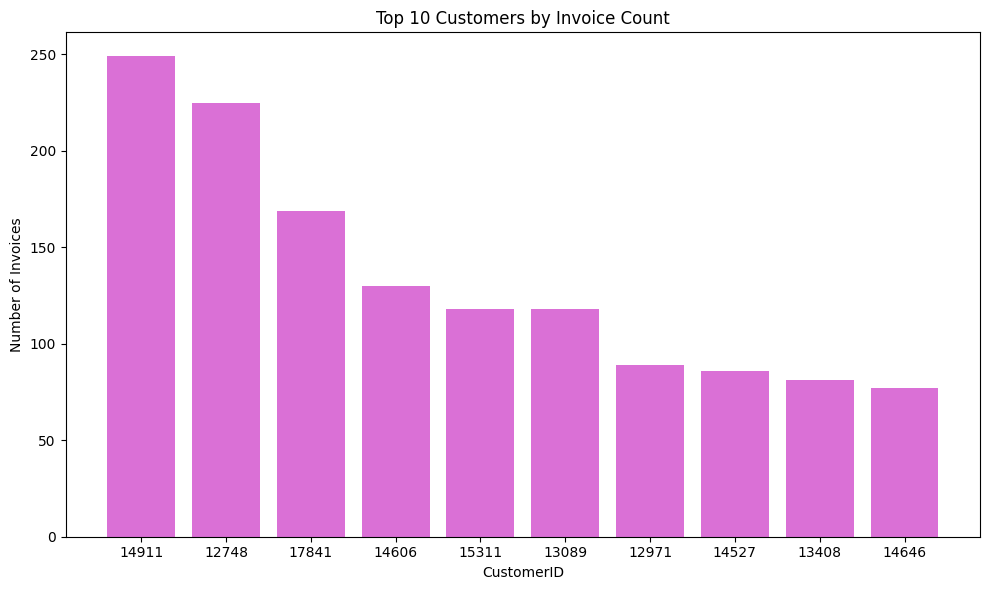

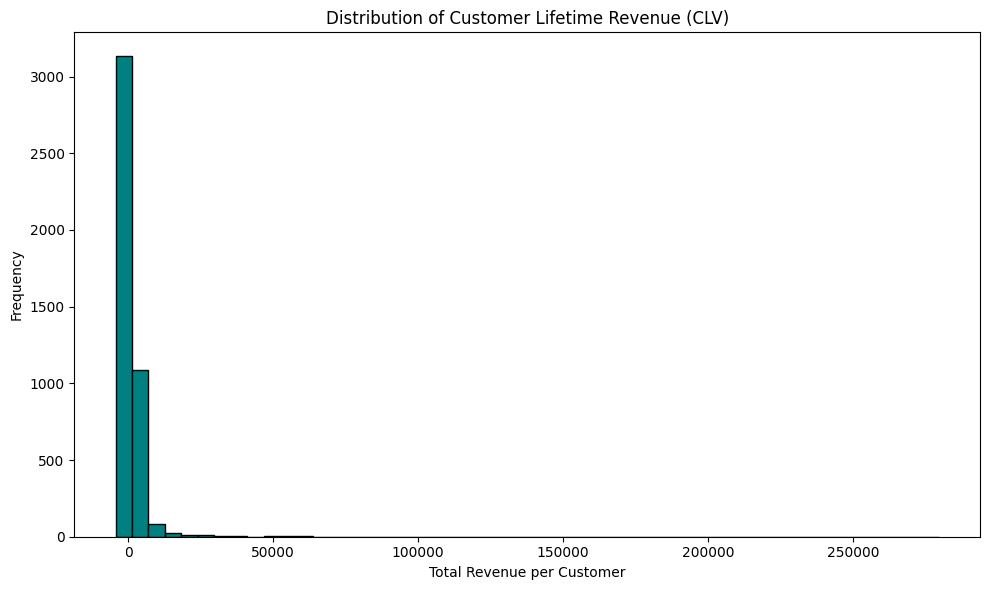

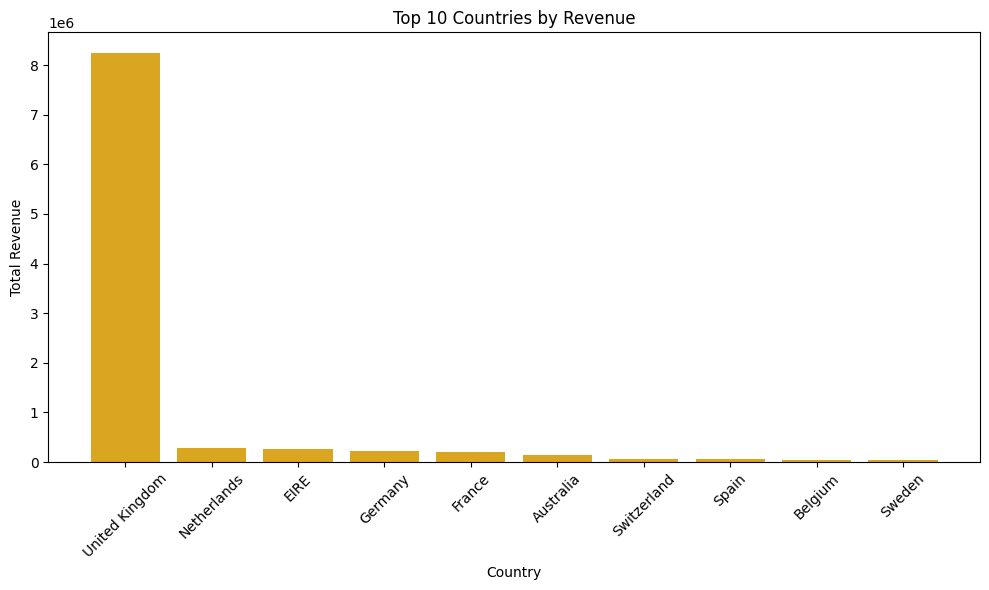

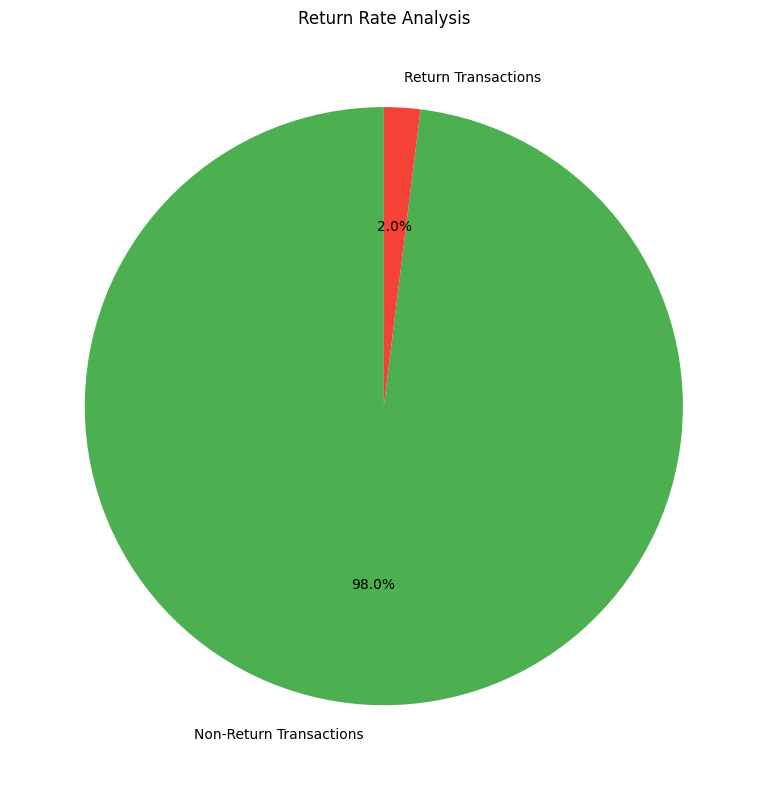

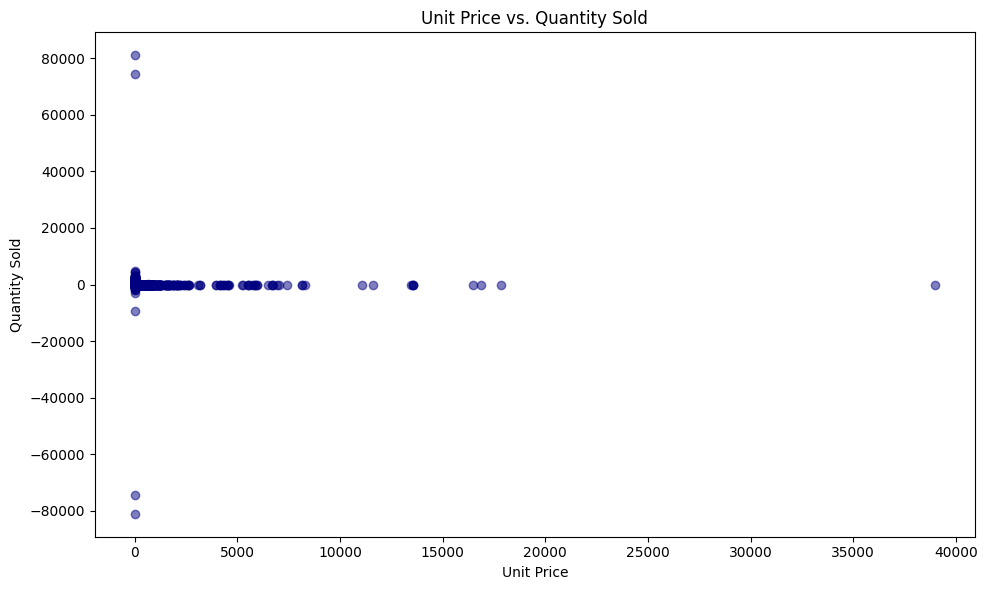


Customer History for CustomerID '17850':
|   CustomerKey |   CustomerID | Country        | EffectiveDate       | EndDate             | IsCurrent   |
|--------------:|-------------:|:---------------|:--------------------|:--------------------|:------------|
|             1 |        17850 | United Kingdom | 2025-03-22 00:00:00 | 2025-03-22 00:00:00 | False       |
|          4381 |        17850 | France         | 2025-03-22 00:00:00 | NaT                 | True        |


In [3]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to DuckDB (assumes your ETL process has loaded data into the "retail" schema)
db_path = "online_retail.duckdb"
con = duckdb.connect(db_path)

# ================================
# 1. Sales & Revenue Analysis
# ================================

# Total Revenue per Month (using DateDimension and FactSales)
sql_monthly = """
SELECT d.Year, d.Month, SUM(f.Revenue) AS TotalRevenue
FROM retail.FactSales f
JOIN retail.DateDimension d ON f.DateKey = d.DateKey
GROUP BY d.Year, d.Month
ORDER BY d.Year, d.Month
"""
df_monthly = con.execute(sql_monthly).df()
df_monthly['YearMonth'] = df_monthly['Year'].astype(str) + '-' + df_monthly['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(12,6))
plt.plot(df_monthly['YearMonth'], df_monthly['TotalRevenue'], marker='o', linestyle='-')
plt.title("Monthly Total Revenue")
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ================================
# 2. Product Performance & Inventory Management
# ================================

# Top 10 Products by Revenue
sql_top_products_revenue = """
SELECT p.Description, SUM(f.Revenue) AS TotalRevenue
FROM retail.FactSales f
JOIN retail.ProductDimension p ON f.ProductKey = p.ProductKey
GROUP BY p.Description
ORDER BY TotalRevenue DESC
LIMIT 10
"""
df_top_products_rev = con.execute(sql_top_products_revenue).df()

plt.figure(figsize=(10,6))
plt.barh(df_top_products_rev['Description'], df_top_products_rev['TotalRevenue'], color='skyblue')
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Top 10 Products by Quantity Sold
sql_top_products_qty = """
SELECT p.Description, SUM(f.Quantity) AS TotalQuantity
FROM retail.FactSales f
JOIN retail.ProductDimension p ON f.ProductKey = p.ProductKey
GROUP BY p.Description
ORDER BY TotalQuantity DESC
LIMIT 10
"""
df_top_products_qty = con.execute(sql_top_products_qty).df()

plt.figure(figsize=(10,6))
plt.barh(df_top_products_qty['Description'], df_top_products_qty['TotalQuantity'], color='lightgreen')
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Total Quantity")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Cross-Sell Opportunities: Top 5 Product Pairs bought together in the same invoice
sql_cross_sell = """
SELECT f1.ProductKey AS ProductKey1, f2.ProductKey AS ProductKey2, COUNT(DISTINCT f1.InvoiceKey) AS PairCount
FROM retail.FactSales f1
JOIN retail.FactSales f2 ON f1.InvoiceKey = f2.InvoiceKey AND f1.ProductKey < f2.ProductKey
GROUP BY f1.ProductKey, f2.ProductKey
ORDER BY PairCount DESC
LIMIT 5
"""
df_cross_sell = con.execute(sql_cross_sell).df()

# Join with ProductDimension to get product descriptions
df_cross_sell = df_cross_sell.merge(
    con.execute("SELECT ProductKey, Description FROM retail.ProductDimension").df(),
    left_on='ProductKey1', right_on='ProductKey', how='left'
).rename(columns={'Description':'Product1'}).drop(columns=['ProductKey'])
df_cross_sell = df_cross_sell.merge(
    con.execute("SELECT ProductKey, Description FROM retail.ProductDimension").df(),
    left_on='ProductKey2', right_on='ProductKey', how='left'
).rename(columns={'Description':'Product2'}).drop(columns=['ProductKey'])

print("Top 5 Product Pairs (Cross-sell Opportunities):")
print(df_cross_sell[['Product1','Product2','PairCount']].to_markdown(index=False))

# ================================
# 3. Customer Segmentation & Loyalty Analysis
# ================================

# Repeat Purchase Behavior: Count invoices per customer
sql_repeat = """
SELECT c.CustomerID, COUNT(DISTINCT i.InvoiceKey) AS InvoiceCount, SUM(f.Revenue) AS TotalRevenue
FROM retail.FactSales f
JOIN retail.CustomerDimension c ON f.CustomerKey = c.CustomerKey
JOIN retail.InvoiceDimension i ON f.InvoiceKey = i.InvoiceKey
GROUP BY c.CustomerID
ORDER BY InvoiceCount DESC
LIMIT 10
"""
df_repeat = con.execute(sql_repeat).df()

plt.figure(figsize=(10,6))
plt.bar(df_repeat['CustomerID'], df_repeat['InvoiceCount'], color='orchid')
plt.title("Top 10 Customers by Invoice Count")
plt.xlabel("CustomerID")
plt.ylabel("Number of Invoices")
plt.tight_layout()
plt.show()

# Customer Lifetime Value (CLV): Histogram of total revenue per customer
sql_clv = """
SELECT c.CustomerID, SUM(f.Revenue) AS TotalRevenue
FROM retail.FactSales f
JOIN retail.CustomerDimension c ON f.CustomerKey = c.CustomerKey
GROUP BY c.CustomerID
"""
df_clv = con.execute(sql_clv).df()

plt.figure(figsize=(10,6))
plt.hist(df_clv['TotalRevenue'], bins=50, color='teal', edgecolor='black')
plt.title("Distribution of Customer Lifetime Revenue (CLV)")
plt.xlabel("Total Revenue per Customer")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Geographical Analysis: Revenue by Country (using InvoiceDimension)
sql_country_rev = """
SELECT Country, SUM(Revenue) AS TotalRevenue
FROM retail.FactSales f
JOIN retail.InvoiceDimension i ON f.InvoiceKey = i.InvoiceKey
GROUP BY Country
ORDER BY TotalRevenue DESC
LIMIT 10
"""
df_country_rev = con.execute(sql_country_rev).df()

plt.figure(figsize=(10,6))
plt.bar(df_country_rev['Country'], df_country_rev['TotalRevenue'], color='goldenrod')
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ================================
# 4. Return & Cancellation Analysis
# ================================

# Calculate return rate: Identify transactions with negative Quantity
sql_return = """
SELECT 
    (SELECT COUNT(*) FROM retail.FactSales) AS TotalTransactions,
    (SELECT COUNT(*) FROM retail.FactSales WHERE Quantity < 0) AS ReturnTransactions
"""
df_return = con.execute(sql_return).df().iloc[0]
total_trans = df_return['TotalTransactions']
return_trans = df_return['ReturnTransactions']
non_return_trans = total_trans - return_trans

labels = ['Non-Return Transactions', 'Return Transactions']
values = [non_return_trans, return_trans]

plt.figure(figsize=(8,8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50','#F44336'])
plt.title("Return Rate Analysis")
plt.tight_layout()
plt.show()

# ================================
# 5. Pricing Strategy
# ================================

# Price Sensitivity: Scatter plot of UnitPrice vs. Quantity sold per transaction
sql_price = "SELECT UnitPrice, Quantity FROM retail.FactSales WHERE UnitPrice > 0"
df_price = con.execute(sql_price).df()

plt.figure(figsize=(10,6))
plt.scatter(df_price['UnitPrice'], df_price['Quantity'], alpha=0.5, color='navy')
plt.title("Unit Price vs. Quantity Sold")
plt.xlabel("Unit Price")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

# ================================
# 6. Historical Change Tracking (SCD Type 2)
# ================================

# Display customer history for a specific customer
sql_customer_history = """
SELECT * FROM retail.CustomerDimension
WHERE CustomerID = '17850'
ORDER BY EffectiveDate
"""
df_customer_history = con.execute(sql_customer_history).df()
print("\nCustomer History for CustomerID '17850':")
print(df_customer_history.to_markdown(index=False))

# Close the connection
con.close()
